In [5]:
%load_ext autoreload
%autoreload 2
#existing packages
import numpy as np
import matplotlib.pyplot as plt
import time

#.py
from core import qlearning as q
from core import prices as pr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
start = time.time()
aggregated_agents = []
for rep in [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]:
    total_rewards = []

    for loop in range(3):
        print("Loop:", loop, "alpha:", rep[0], "beta:", rep[1])
        agents = [q.Agent(alpha=rep[0], beta=rep[1], doubleQ=True) for _ in range(2)]
        env = q.Env()

        temps = []
        rewards = []
        epsilon = []
        prices = []

        # Initialisation des prix p0 (on va le faire directement dans chaque agent)
        for agent in agents:
            agent.p = np.random.choice(agent.A)

        # Initialisation de l'état
        s_t = env([agent.p for agent in agents])[1]
        for agent in agents:
            agent.s_t = s_t

        s_ind = agents[0].find_index(agents[0].s_t)
        for agent in agents:
            agent.s_ind = s_ind

        # Phase itérative
        for t in range(1000):
            # Actions et état t+1
            for agent in agents:
                agent.a_ind = agent.get_next_action()

            s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
            for agent in agents:
                agent.s_t1 = s_t1

            s_ind1 = agents[0].find_index(agents[0].s_t1)
            for agent in agents:
                agent.s_ind1 = s_ind1

            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret

            re = ret[0]*ret[1]-ret[0]*ret[2]
            rewards.append(re)
            epsilon_values = [agent.epsilon for agent in agents]
            epsilon.append(epsilon_values)
            prices.append([agent.p for agent in agents])

            for i, agent in enumerate(agents):
                agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)

        total_rewards.append(rewards)

    aggregated_agents.append(np.array(total_rewards).mean(axis=0))
end = time.time()

print(aggregated_agents)
print(end-start)

Loop: 0 alpha: 0.025 beta: 1e-06
Loop: 1 alpha: 0.025 beta: 1e-06
Loop: 2 alpha: 0.025 beta: 1e-06
Loop: 0 alpha: 0.1 beta: 5e-06
Loop: 1 alpha: 0.1 beta: 5e-06
Loop: 2 alpha: 0.1 beta: 5e-06
Loop: 0 alpha: 0.2 beta: 1e-05
Loop: 1 alpha: 0.2 beta: 1e-05
Loop: 2 alpha: 0.2 beta: 1e-05
Loop: 0 alpha: 0.05 beta: 1.5000000000000002e-05
Loop: 1 alpha: 0.05 beta: 1.5000000000000002e-05
Loop: 2 alpha: 0.05 beta: 1.5000000000000002e-05
Loop: 0 alpha: 0.2 beta: 1e-06
Loop: 1 alpha: 0.2 beta: 1e-06
Loop: 2 alpha: 0.2 beta: 1e-06
[array([[0.2560617 , 0.31194599],
       [0.23459184, 0.29462056],
       [0.3239547 , 0.2868178 ],
       ...,
       [0.24873941, 0.32080968],
       [0.35910256, 0.19979817],
       [0.26001662, 0.2617519 ]]), array([[0.33350023, 0.21791658],
       [0.30852273, 0.22833419],
       [0.31606472, 0.25840717],
       ...,
       [0.2593645 , 0.31424981],
       [0.26964339, 0.23750531],
       [0.30916157, 0.24400308]]), array([[0.25493393, 0.28902556],
       [0.2735318

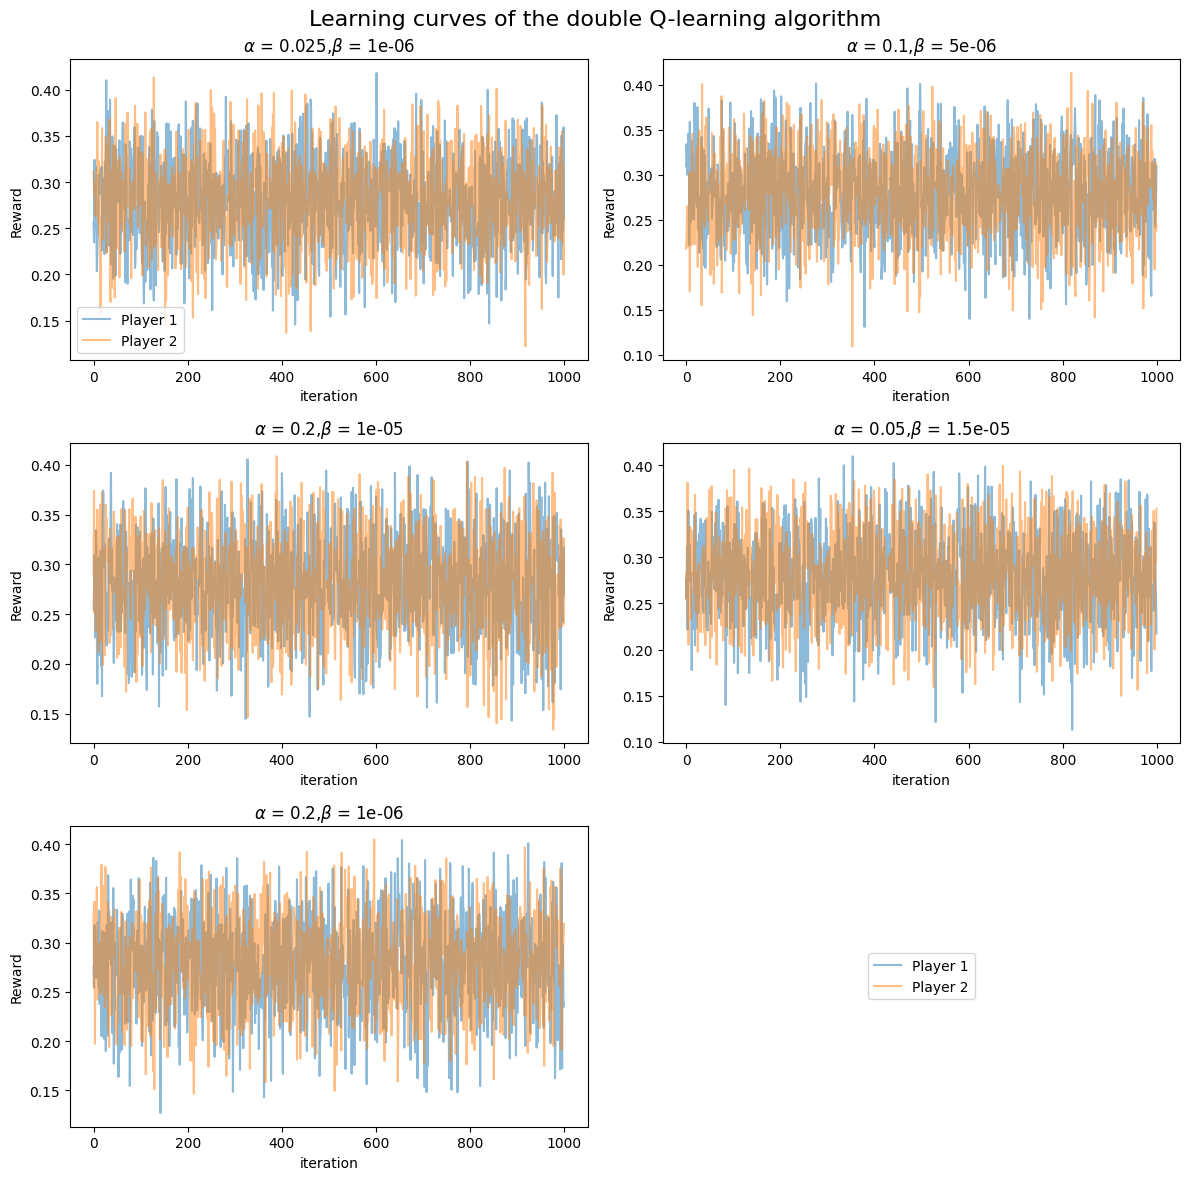

In [3]:
num_players = 2
num_graphs = len(aggregated_agents)
rep = [[0.025,10**(-6)],[0.1,0.5*10**(-5)],[0.2,10**(-5)],[0.05,1.5*10**(-5)],[0.2,10**(-6)]]

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(aggregated_agents[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(aggregated_agents[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\alpha$ = {rep[graph_num][0]},$\\beta$ = {round(rep[graph_num][1],8)}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend()

# Remove any unused subplots
if num_graphs < 5:
    for i in range(num_graphs, 5):
        fig.delaxes(axes[i])

# Create a legend in the last subplot
legend_ax = axes[-1]
legend_ax.axis('off')

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()

# Create the legend in the last subplot
legend_ax.legend(handles, labels, loc='center')


fig.suptitle('Learning curves of the double Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [6]:
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit
    
Rmean = np.zeros((len(aggregated_agents), 2))
DRmean = np.zeros((len(aggregated_agents), 2))   
    
for i in range (len(aggregated_agents)): 
    for j in range (2):
        Rmean[i][j] = aggregated_agents[i][-100:,j].mean()
        DRmean[i][j] = (Rmean[i][j] - RN)/(RC - RN) 

print(DRmean)

[[0.53150734 0.51870038]
 [0.52316627 0.49902521]
 [0.46447699 0.48082271]
 [0.52630387 0.49781107]
 [0.47320625 0.56060353]]


[0.52510386 0.51109574 0.47264985 0.51205747 0.51690489]


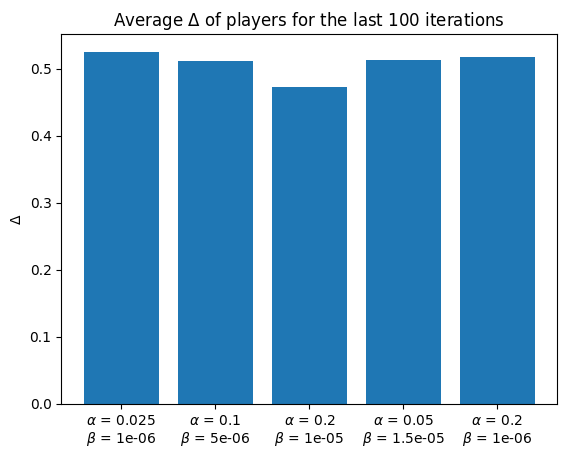

In [7]:
av = np.mean(DRmean, axis=1)
print(av)
fig.set_size_inches(8, 16)
plt.bar([f'$\\alpha$ = {rep[graph_num][0]}\n$\\beta$ = {round(rep[graph_num][1],8)}' for graph_num 
         in range(len(rep))],av)
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations')
plt.show()